In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)

        self.x = df[['전류(A)', '누적_용량(Ah)', '절대값_용량(Ah)']].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))

        self.y = df.iloc[:, 7:8].values
        
        self.length = len(df)

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [3]:
dataset = CustomDataset("180801_RFB_510cy_006_DC.csv")
print(dataset.x.shape)
print(dataset.x.dtype)
print(dataset.y.shape)
print(dataset.y.dtype)

(262407, 3)
float64
(262407, 1)
float64


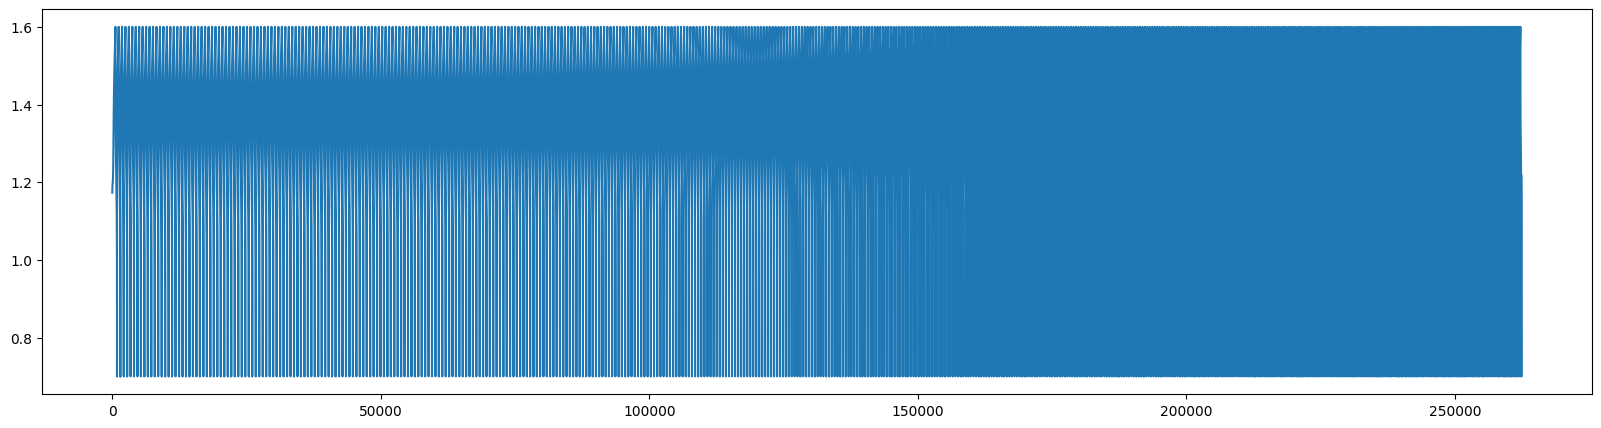

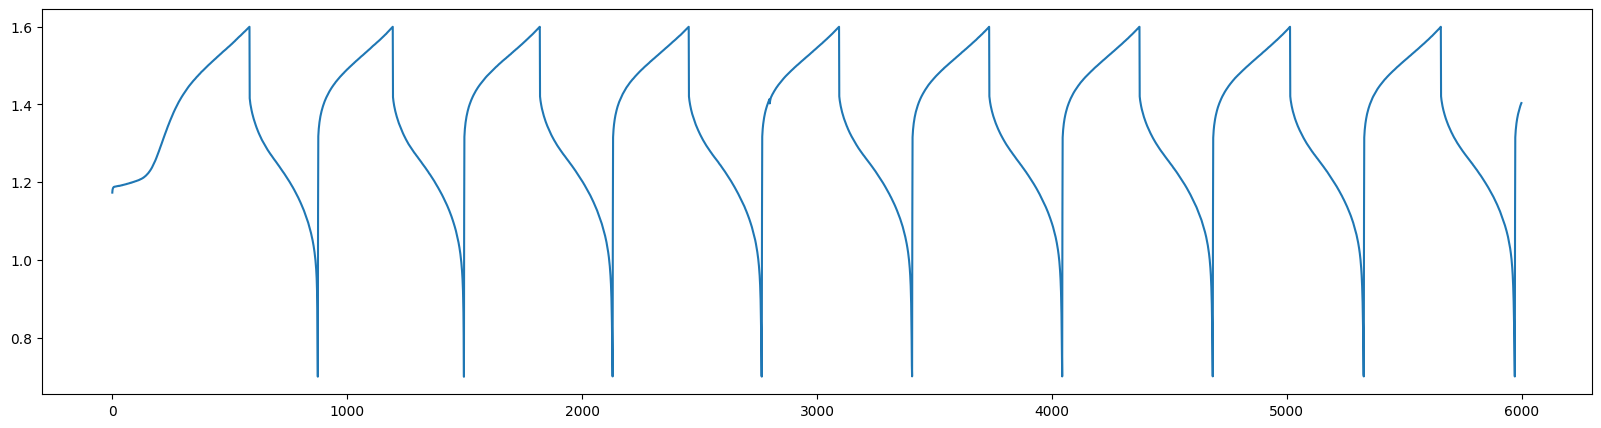

In [4]:
plt.figure(figsize=(20,5))
plt.plot(dataset.y)

plt.figure(figsize=(20,5))
plt.plot(dataset.y[:6000])
plt.show()

In [5]:
# X_train = X[:200000]
# X_test = X[200000:]

# y_train = y[:200000]
# y_test = y[200000:] 

# print(X_train.dtypes)
# print("Training Shape", X_train.shape, y_train.shape)
# print("Testing Shape", X_test.shape, y_test.shape) 

dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

# X_train = X[:train_size]
# X_val = X[train_size:(train_size + validation_size)]
# X_test = X[(train_size + validation_size):(train_size + validation_size +test_size)]



print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 209925
Validation Data Size : 26240
Testing Data Size : 26242


In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=False, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=256, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last=True)

In [7]:
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.batchnormal = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes) 

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        
        output, (hn) = self.gru(x, (h_0)) 
        hn = hn.view(-1, self.hidden_size) 
        out = self.relu(hn)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out)
        return out

In [8]:
num_epochs = 1000 
learning_rate = 0.001

input_size = 3
hidden_size = 32
num_layers = 1 

num_classes = 1

model = GRU(num_classes, input_size, hidden_size, num_layers, dataset.x.shape[1])
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
writer = SummaryWriter()

def training(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))
    for i, data in prog_bar:
        counter += 1
        data, target = data[0], data[1]
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

In [10]:
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))
    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target = data[0], data[1]
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct / total
        return val_loss, val_accuracy

In [11]:
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
start = time.time()
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    train_epoch_loss, train_epoch_accuracy = training(
        model, train_dataloader, train_dataset, optimizer, criterion
    )
    writer.add_scalar("Loss/train", train_epoch_loss, epoch)
    val_epoch_loss, val_epoch_accuracy = validate(
        model, validation_dataloader, validation_dataset, criterion
    )
    writer.add_scalar("Loss/val", val_epoch_loss, epoch)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    if epoch % 100 == 0:
        print("Train Loss: %e, Train Acc: %.2f" %(train_epoch_loss, train_epoch_accuracy))
        print('Val Loss: %e, Val Acc: %.2f' %(val_epoch_loss, val_epoch_accuracy))
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

writer.flush()
writer.close()

Epoch 1 of 1000
Training


  0%|          | 0/820 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_15140\1130521825.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  feature = torch.FloatTensor([self.x[index]])
100%|██████████| 820/820 [00:02<00:00, 290.61it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 300.63it/s]


Train Loss: 1.005807e-01, Train Acc: 0.00
Val Loss: 8.047819e-03, Val Acc: 0.00
Epoch 2 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 301.78it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.32it/s]


Epoch 3 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.77it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 414.55it/s]


Epoch 4 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.30it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.86it/s]


Epoch 5 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 304.28it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.59it/s]


Epoch 6 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.71it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.86it/s]


Epoch 7 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.59it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.54it/s]


Epoch 8 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 306.62it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 408.68it/s]


Epoch 9 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.48it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.27it/s]


Epoch 10 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.36it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.37it/s]


Epoch 11 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 303.19it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.17it/s]


Epoch 12 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 257.87it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 356.61it/s]


Epoch 13 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 256.48it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 357.88it/s]


Epoch 14 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.40it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 301.49it/s]


Epoch 15 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.63it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 397.97it/s]


Epoch 16 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.77it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 400.85it/s]


Epoch 17 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.64it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.02it/s]


Epoch 18 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.94it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 400.50it/s]


Epoch 19 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.26it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 403.74it/s]


Epoch 20 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.40it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.06it/s]


Epoch 21 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.74it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 360.21it/s]


Epoch 22 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 259.61it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.19it/s]


Epoch 23 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.40it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 405.00it/s]


Epoch 24 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 302.81it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 306.41it/s]


Epoch 25 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.60it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.37it/s]


Epoch 26 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.63it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.36it/s]


Epoch 27 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.15it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 28 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 302.82it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 29 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.23it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.37it/s]


Epoch 30 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.91it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 31 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 304.95it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 32 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.35it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 367.23it/s]


Epoch 33 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.86it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 34 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 301.15it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 35 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.56it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 36 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.05it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 372.15it/s]


Epoch 37 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 305.06it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 306.26it/s]


Epoch 38 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 305.59it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.37it/s]


Epoch 39 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.52it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 40 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.13it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 41 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.26it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 42 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.43it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.76it/s]


Epoch 43 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.51it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 364.20it/s]


Epoch 44 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.47it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 45 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.54it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 46 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.44it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 47 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.26it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 363.88it/s]


Epoch 48 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.51it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 49 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.89it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 50 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.73it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 304.59it/s]


Epoch 51 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.53it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 52 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.63it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 53 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.27it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 54 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.62it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 361.44it/s]


Epoch 55 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.20it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 56 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.37it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 376.26it/s]


Epoch 57 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.36it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 58 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.52it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 59 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.59it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 60 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.36it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 304.53it/s]


Epoch 61 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.22it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 62 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.39it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 400.29it/s]


Epoch 63 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.11it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 64 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.56it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 65 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.22it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 66 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.01it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 414.34it/s]


Epoch 67 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 307.25it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 416.02it/s]


Epoch 68 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.88it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.74it/s]


Epoch 69 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.81it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 70 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.17it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 71 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.10it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 72 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.18it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 73 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.80it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 312.36it/s]


Epoch 74 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.87it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 75 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.24it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 76 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.39it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 77 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.35it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 373.51it/s]


Epoch 78 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.61it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 79 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.92it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 80 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.80it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 81 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.26it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 82 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.76it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 83 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.58it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 302.35it/s]


Epoch 84 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.79it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 85 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.47it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.09it/s]


Epoch 86 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.73it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 87 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.08it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 88 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.95it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 89 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.78it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 90 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.18it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 91 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.19it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 92 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 270.40it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 386.19it/s]


Epoch 93 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.54it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 94 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.46it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 95 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.65it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 96 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.19it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 302.93it/s]


Epoch 97 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.31it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 98 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.67it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 368.13it/s]


Epoch 99 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.62it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 400.18it/s]


Epoch 100 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.68it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 101 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.49it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Train Loss: 8.692665e-05, Train Acc: 0.00
Val Loss: 6.300103e-05, Val Acc: 0.00
Epoch 102 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.45it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 103 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.08it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 104 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.24it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 105 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.00it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 106 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.29it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 304.57it/s]


Epoch 107 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.84it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 108 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.64it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 109 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.01it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 110 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.21it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 111 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.49it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 112 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.72it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 113 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.90it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 114 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.83it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 115 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.48it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 405.01it/s]


Epoch 116 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.79it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 117 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.04it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 118 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.88it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 119 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.82it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 296.64it/s]


Epoch 120 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.97it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 121 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.33it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 414.34it/s]


Epoch 122 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.87it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 123 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.12it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 124 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.19it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 125 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.40it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 362.91it/s]


Epoch 126 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.44it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 127 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.31it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 128 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.46it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 129 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.74it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 304.59it/s]


Epoch 130 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.62it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 131 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.20it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.36it/s]


Epoch 132 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.58it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 133 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.86it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 134 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.95it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 135 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.35it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 352.90it/s]


Epoch 136 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.06it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 137 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.24it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 138 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.79it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 139 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.99it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 140 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.77it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 141 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.40it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 142 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.06it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 261.74it/s]


Epoch 143 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.00it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 144 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.30it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 145 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.38it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 146 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.63it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 416.02it/s]


Epoch 147 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.11it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 414.04it/s]


Epoch 148 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.45it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 416.02it/s]


Epoch 149 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 302.74it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 415.93it/s]


Epoch 150 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 255.26it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 151 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.88it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 152 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.86it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 285.06it/s]


Epoch 153 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.96it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 154 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.91it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 155 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.80it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 156 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.56it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 157 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.13it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 158 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.57it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 159 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.48it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 160 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.78it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 161 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.16it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 162 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.71it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 163 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.38it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 164 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.31it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 165 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.21it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 283.77it/s]


Epoch 166 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 262.69it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 380.32it/s]


Epoch 167 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.14it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 168 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.10it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 169 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.54it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 170 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.46it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 171 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.31it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 172 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.39it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 384.74it/s]


Epoch 173 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.38it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 174 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.18it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 175 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.29it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 300.04it/s]


Epoch 176 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.34it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 177 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.43it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 178 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.33it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 355.02it/s]


Epoch 179 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.67it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.61it/s]


Epoch 180 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.16it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 181 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 276.53it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 387.73it/s]


Epoch 182 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.88it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 183 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.09it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 184 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.23it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 185 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.03it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 186 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.45it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 187 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.74it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 188 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.88it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 300.12it/s]


Epoch 189 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.41it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 190 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.40it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 191 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.02it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 192 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.70it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 193 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.24it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 387.66it/s]


Epoch 194 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.59it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 195 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.24it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 196 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.05it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 197 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.01it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.78it/s]


Epoch 198 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.81it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 303.96it/s]


Epoch 199 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.75it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 200 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.16it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 410.17it/s]


Epoch 201 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.06it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 368.26it/s]


Train Loss: 3.788728e-05, Train Acc: 0.00
Val Loss: 3.463214e-05, Val Acc: 0.00
Epoch 202 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.80it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.36it/s]


Epoch 203 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.76it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 361.63it/s]


Epoch 204 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.48it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 205 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.61it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 206 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.72it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 207 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.30it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 208 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.06it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 209 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.99it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 380.45it/s]


Epoch 210 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.95it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.36it/s]


Epoch 211 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 301.45it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 308.76it/s]


Epoch 212 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 300.05it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 213 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.28it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 214 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.39it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 215 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.77it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 216 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.67it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 217 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.58it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 218 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.04it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.36it/s]


Epoch 219 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.62it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 364.20it/s]


Epoch 220 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.39it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 221 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.85it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 416.02it/s]


Epoch 222 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 255.93it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 380.50it/s]


Epoch 223 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 269.12it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.36it/s]


Epoch 224 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.93it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 309.20it/s]


Epoch 225 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 301.26it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 416.02it/s]


Epoch 226 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.13it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.36it/s]


Epoch 227 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.68it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.37it/s]


Epoch 228 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.94it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 229 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.50it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 230 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.52it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 414.00it/s]


Epoch 231 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.61it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 232 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.27it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 233 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.11it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 416.02it/s]


Epoch 234 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.54it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 309.46it/s]


Epoch 235 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.74it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 362.91it/s]


Epoch 236 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 268.83it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 237 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.15it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 238 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.26it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 239 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.75it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 240 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.39it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.35it/s]


Epoch 241 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.41it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 242 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 272.99it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 243 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.17it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 244 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.28it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 245 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 274.67it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 354.12it/s]


Epoch 246 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.07it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 247 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.00it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 302.63it/s]


Epoch 248 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.77it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 249 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.05it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 250 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.55it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 387.20it/s]


Epoch 251 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 274.08it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 252 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.24it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.01it/s]


Epoch 253 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.55it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 254 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.18it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 255 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.76it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 256 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.72it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 257 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.16it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 304.59it/s]


Epoch 258 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.80it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 259 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.21it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 260 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.08it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 261 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.82it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 262 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.95it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 263 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.80it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 264 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.74it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 265 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.98it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 266 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.24it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 376.06it/s]


Epoch 267 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.28it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 268 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.05it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 269 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.64it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.37it/s]


Epoch 270 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.82it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 309.60it/s]


Epoch 271 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.38it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 272 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.81it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 273 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.77it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.36it/s]


Epoch 274 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 301.37it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.37it/s]


Epoch 275 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.58it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 416.02it/s]


Epoch 276 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.06it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.27it/s]


Epoch 277 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 300.49it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 278 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.17it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.36it/s]


Epoch 279 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.25it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 280 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 305.97it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 312.02it/s]


Epoch 281 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 305.76it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 419.43it/s]


Epoch 282 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.47it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 283 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.30it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 284 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 300.16it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 369.03it/s]


Epoch 285 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.00it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 414.34it/s]


Epoch 286 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.18it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 287 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.21it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 288 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 273.97it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 289 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.84it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 290 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.34it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.36it/s]


Epoch 291 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.17it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 292 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.82it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.36it/s]


Epoch 293 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 300.93it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 312.28it/s]


Epoch 294 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.08it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.37it/s]


Epoch 295 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.16it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 419.43it/s]


Epoch 296 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.31it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 416.02it/s]


Epoch 297 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.14it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 298 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.60it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 383.30it/s]


Epoch 299 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.74it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 300 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.66it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 414.34it/s]


Epoch 301 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.43it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Train Loss: 3.350370e-05, Train Acc: 0.00
Val Loss: 1.988166e-05, Val Acc: 0.00
Epoch 302 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 274.26it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 303 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.72it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 312.97it/s]


Epoch 304 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 302.25it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 305 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.78it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 306 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.22it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 307 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 302.29it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 308 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.79it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.37it/s]


Epoch 309 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.72it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 310 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.64it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 311 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.74it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 312 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.31it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 313 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.83it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 314 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.47it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 315 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 256.79it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 316 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.28it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 301.47it/s]


Epoch 317 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.68it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 394.35it/s]


Epoch 318 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 276.91it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 319 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.32it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 320 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.67it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 321 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.22it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.62it/s]


Epoch 322 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.85it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 323 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.98it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 324 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 276.75it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 325 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.58it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 326 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.36it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 354.02it/s]


Epoch 327 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 256.85it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 328 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.80it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 329 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.81it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 370.80it/s]


Epoch 330 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 300.28it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 331 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.68it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 332 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.86it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 368.13it/s]


Epoch 333 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.87it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 334 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.44it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 335 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.33it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 368.14it/s]


Epoch 336 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.18it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 337 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.56it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 338 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.29it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 370.80it/s]


Epoch 339 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.13it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 312.02it/s]


Epoch 340 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.83it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 341 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.10it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 359.09it/s]


Epoch 342 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.68it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 343 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.56it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 344 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 268.08it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 345 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.39it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 346 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.63it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 347 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.79it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.37it/s]


Epoch 348 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.29it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 349 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.67it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.66it/s]


Epoch 350 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.54it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 351 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.68it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 352 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.89it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 307.36it/s]


Epoch 353 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.16it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 354 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.03it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 355 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.66it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 356 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.43it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.36it/s]


Epoch 357 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.51it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 358 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.54it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.36it/s]


Epoch 359 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.76it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 360 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.90it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 361 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.21it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.11it/s]


Epoch 362 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.15it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 298.02it/s]


Epoch 363 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 300.51it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.36it/s]


Epoch 364 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.13it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 365 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.53it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 366 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.28it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 414.34it/s]


Epoch 367 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.17it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 414.34it/s]


Epoch 368 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.56it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 369 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.71it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 370 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.98it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 358.67it/s]


Epoch 371 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.38it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 372 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.36it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 373 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.07it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 370.80it/s]


Epoch 374 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.26it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 375 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.84it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 309.01it/s]


Epoch 376 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.13it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 360.36it/s]


Epoch 377 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.27it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 378 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.66it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 379 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.64it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 364.30it/s]


Epoch 380 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.79it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 381 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.15it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 382 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.78it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 383 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.31it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 384 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.22it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 385 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.88it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 304.70it/s]


Epoch 386 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.82it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 384.74it/s]


Epoch 387 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.43it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.62it/s]


Epoch 388 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.80it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 389 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.51it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 390 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.72it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 391 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.13it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 392 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.82it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 393 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.96it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 367.20it/s]


Epoch 394 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.32it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 394.78it/s]


Epoch 395 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.41it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 396 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.42it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 364.20it/s]


Epoch 397 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.94it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 398 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.64it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 305.43it/s]


Epoch 399 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.20it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 400 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.63it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 401 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.64it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Train Loss: 2.704169e-05, Train Acc: 0.00
Val Loss: 3.017482e-05, Val Acc: 0.00
Epoch 402 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.95it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 403 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.02it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 404 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.97it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 405 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.08it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 406 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.15it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 407 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.15it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 408 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.47it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 300.99it/s]


Epoch 409 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.32it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 410 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.99it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 369.14it/s]


Epoch 411 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.05it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 412 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.44it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 413 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.57it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 362.91it/s]


Epoch 414 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.26it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 415 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.14it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 416 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.15it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 361.63it/s]


Epoch 417 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.44it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.71it/s]


Epoch 418 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.49it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 419 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.28it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 420 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.25it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 421 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.49it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 279.46it/s]


Epoch 422 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.37it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 423 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.96it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 424 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.80it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 425 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.76it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 426 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.27it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 427 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.36it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 370.03it/s]


Epoch 428 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.27it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 429 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.16it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 430 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.32it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 431 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.82it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 303.68it/s]


Epoch 432 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.52it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 433 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.34it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 434 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 274.03it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 435 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.57it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 389.13it/s]


Epoch 436 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 276.17it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 437 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.50it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 389.13it/s]


Epoch 438 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.97it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 397.98it/s]


Epoch 439 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 273.27it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 440 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.95it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 441 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.97it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 362.19it/s]


Epoch 442 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.07it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 443 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.44it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 444 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.05it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 303.64it/s]


Epoch 445 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.05it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 446 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 267.56it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.62it/s]


Epoch 447 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 275.44it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 448 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.37it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.69it/s]


Epoch 449 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.84it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 360.32it/s]


Epoch 450 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.49it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 451 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.46it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 452 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.14it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 453 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.59it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 397.48it/s]


Epoch 454 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.62it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 455 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.46it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 389.13it/s]


Epoch 456 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 265.89it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 391.65it/s]


Epoch 457 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.23it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 366.81it/s]


Epoch 458 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.76it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 459 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.52it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.37it/s]


Epoch 460 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.29it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 461 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.30it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 400.29it/s]


Epoch 462 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.57it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 463 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.57it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 464 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.24it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.39it/s]


Epoch 465 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.34it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 364.20it/s]


Epoch 466 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.46it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 467 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.98it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 304.52it/s]


Epoch 468 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.29it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 469 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.51it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 470 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.95it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.80it/s]


Epoch 471 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.90it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 472 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.72it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 408.76it/s]


Epoch 473 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.74it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 400.41it/s]


Epoch 474 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.29it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 475 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.32it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 476 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.97it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 414.34it/s]


Epoch 477 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 301.33it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 414.34it/s]


Epoch 478 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.41it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 479 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.35it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 480 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.23it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.79it/s]


Epoch 481 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.93it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 482 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 270.36it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 483 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.05it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.58it/s]


Epoch 484 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.19it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 345.60it/s]


Epoch 485 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.25it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 486 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.28it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 487 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.65it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 488 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.50it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 489 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.30it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 490 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.56it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 306.30it/s]


Epoch 491 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.08it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.00it/s]


Epoch 492 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.38it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 372.08it/s]


Epoch 493 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.60it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 494 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.53it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 495 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.08it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 376.25it/s]


Epoch 496 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.35it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 497 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.29it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 498 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.35it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 385.55it/s]


Epoch 499 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.00it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 500 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.36it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 501 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.75it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Train Loss: 2.486704e-05, Train Acc: 0.00
Val Loss: 1.883519e-05, Val Acc: 0.00
Epoch 502 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.23it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 503 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.22it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 293.31it/s]


Epoch 504 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.53it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 505 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.90it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.01it/s]


Epoch 506 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.07it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 507 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 303.71it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 414.34it/s]


Epoch 508 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.66it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 509 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.95it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.99it/s]


Epoch 510 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 300.38it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 416.02it/s]


Epoch 511 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.69it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 362.91it/s]


Epoch 512 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.42it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 513 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 304.61it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 314.60it/s]


Epoch 514 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.85it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 515 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.59it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 516 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.19it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 517 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.38it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 518 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.15it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 519 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.36it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 370.62it/s]


Epoch 520 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.38it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 521 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.65it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 522 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.25it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 523 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.30it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 524 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.08it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 525 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.07it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 526 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 300.49it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 306.17it/s]


Epoch 527 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.31it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 528 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.41it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.00it/s]


Epoch 529 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.04it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 414.34it/s]


Epoch 530 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.83it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 366.81it/s]


Epoch 531 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.39it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.37it/s]


Epoch 532 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.91it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.04it/s]


Epoch 533 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.77it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 534 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.08it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 535 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.34it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.37it/s]


Epoch 536 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.85it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 309.23it/s]


Epoch 537 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.97it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 414.34it/s]


Epoch 538 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.88it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 539 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.48it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 540 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.96it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 541 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.70it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 355.08it/s]


Epoch 542 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.10it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 543 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.10it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.36it/s]


Epoch 544 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.17it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 545 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.96it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 546 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.52it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 547 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 275.28it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 548 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.91it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 549 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.56it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 305.50it/s]


Epoch 550 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.11it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 551 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.22it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 397.38it/s]


Epoch 552 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 268.19it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 553 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.81it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 554 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.16it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 555 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 268.33it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 556 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.64it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 557 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.77it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 558 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.24it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 416.02it/s]


Epoch 559 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.31it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 306.39it/s]


Epoch 560 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.89it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 561 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.09it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 562 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.80it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 362.63it/s]


Epoch 563 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 300.23it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 410.37it/s]


Epoch 564 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.51it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 414.34it/s]


Epoch 565 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.08it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 416.02it/s]


Epoch 566 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 302.59it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 416.02it/s]


Epoch 567 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.06it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 329.07it/s]


Epoch 568 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 270.15it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 569 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.45it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.90it/s]


Epoch 570 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.39it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 571 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.24it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 572 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.80it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 300.59it/s]


Epoch 573 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.02it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 403.48it/s]


Epoch 574 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.78it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.78it/s]


Epoch 575 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.98it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 376.26it/s]


Epoch 576 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.54it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 577 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.58it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.55it/s]


Epoch 578 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.01it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 579 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.49it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 580 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.70it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 581 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 276.53it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 582 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.97it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 300.16it/s]


Epoch 583 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.29it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 361.63it/s]


Epoch 584 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.79it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 585 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.50it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 586 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.40it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 587 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.02it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 588 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.42it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 589 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.01it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 590 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.09it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 591 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.47it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 360.36it/s]


Epoch 592 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.99it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 593 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 269.74it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 594 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.10it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 384.51it/s]


Epoch 595 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.18it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 299.87it/s]


Epoch 596 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.28it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 597 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.40it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 598 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.87it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 599 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.42it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 355.35it/s]


Epoch 600 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.38it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.37it/s]


Epoch 601 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.65it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 405.99it/s]


Train Loss: 2.165681e-05, Train Acc: 0.00
Val Loss: 1.899613e-05, Val Acc: 0.00
Epoch 602 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.65it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.62it/s]


Epoch 603 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.29it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 604 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.88it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 605 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.31it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 309.36it/s]


Epoch 606 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.27it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 607 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.27it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 608 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.61it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 609 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.74it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.17it/s]


Epoch 610 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.12it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.95it/s]


Epoch 611 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.61it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 612 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.99it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.43it/s]


Epoch 613 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 272.69it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 614 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.80it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 615 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.05it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 365.65it/s]


Epoch 616 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.68it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 617 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.33it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 394.40it/s]


Epoch 618 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.18it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 303.68it/s]


Epoch 619 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.36it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 620 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.88it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 386.19it/s]


Epoch 621 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.43it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 622 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.19it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 623 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.87it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 367.82it/s]


Epoch 624 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.73it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 625 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.83it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 626 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.51it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 414.34it/s]


Epoch 627 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 276.22it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 628 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.68it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 629 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.46it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 630 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.54it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 631 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.43it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 360.54it/s]


Epoch 632 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.78it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 633 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.45it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 634 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.33it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 635 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.40it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 636 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 276.99it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 637 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.35it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 638 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.34it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 639 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.99it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 366.82it/s]


Epoch 640 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.95it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 416.02it/s]


Epoch 641 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.82it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 310.12it/s]


Epoch 642 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.53it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.74it/s]


Epoch 643 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.87it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 644 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.61it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 645 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.01it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 410.29it/s]


Epoch 646 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.07it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 647 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.38it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 369.46it/s]


Epoch 648 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.40it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 649 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.92it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 650 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.66it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 651 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.74it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 652 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.89it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 384.74it/s]


Epoch 653 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.77it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 654 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.61it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 405.96it/s]


Epoch 655 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.70it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 374.88it/s]


Epoch 656 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.39it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 657 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.77it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 403.17it/s]


Epoch 658 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.57it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 659 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.96it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 660 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.56it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 661 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.95it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 662 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.06it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 381.87it/s]


Epoch 663 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.94it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 664 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.00it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 301.86it/s]


Epoch 665 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.31it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 666 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.13it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 410.81it/s]


Epoch 667 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.04it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 668 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.82it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 403.94it/s]


Epoch 669 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.87it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 670 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.83it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 671 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.47it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 672 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 255.33it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 384.55it/s]


Epoch 673 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.60it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 361.63it/s]


Epoch 674 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.95it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 675 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.85it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 676 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.88it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 677 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.52it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 284.28it/s]


Epoch 678 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.63it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 679 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.50it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 680 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.87it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 681 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.68it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 397.02it/s]


Epoch 682 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.13it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 683 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.70it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 684 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.92it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.62it/s]


Epoch 685 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.29it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 686 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.61it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 387.98it/s]


Epoch 687 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.77it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 302.09it/s]


Epoch 688 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.58it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 689 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.70it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 394.94it/s]


Epoch 690 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.75it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.61it/s]


Epoch 691 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.67it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 692 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.44it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 693 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.57it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 338.88it/s]


Epoch 694 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.53it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 695 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.09it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.34it/s]


Epoch 696 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.38it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 697 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.29it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.30it/s]


Epoch 698 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.03it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 699 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.32it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.42it/s]


Epoch 700 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.05it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 306.49it/s]


Epoch 701 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.84it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 371.68it/s]


Train Loss: 1.962551e-05, Train Acc: 0.00
Val Loss: 1.456657e-05, Val Acc: 0.00
Epoch 702 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.60it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 703 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.66it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 400.65it/s]


Epoch 704 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.21it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.36it/s]


Epoch 705 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.46it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.13it/s]


Epoch 706 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.94it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 707 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 254.96it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 370.80it/s]


Epoch 708 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.57it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 709 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.69it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 335.62it/s]


Epoch 710 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.42it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 310.18it/s]


Epoch 711 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.90it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 712 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.26it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 713 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.44it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.41it/s]


Epoch 714 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.52it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 368.13it/s]


Epoch 715 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.58it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 716 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.98it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 717 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.39it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 381.67it/s]


Epoch 718 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.39it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.37it/s]


Epoch 719 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.23it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 720 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.51it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 721 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.45it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 722 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.08it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 723 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.28it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 279.15it/s]


Epoch 724 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.49it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 725 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.42it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.63it/s]


Epoch 726 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.95it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 727 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.61it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 373.12it/s]


Epoch 728 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.14it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 729 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.90it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 730 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.10it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 372.15it/s]


Epoch 731 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.99it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 732 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 272.04it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 733 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.47it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 299.24it/s]


Epoch 734 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.57it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.45it/s]


Epoch 735 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 274.72it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 736 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.17it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 737 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.30it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 383.30it/s]


Epoch 738 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.58it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 739 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.16it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 387.66it/s]


Epoch 740 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.16it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 741 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.03it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.62it/s]


Epoch 742 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.26it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 352.80it/s]


Epoch 743 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.02it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.12it/s]


Epoch 744 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.27it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 745 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.25it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 397.57it/s]


Epoch 746 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.92it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 301.94it/s]


Epoch 747 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.78it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 365.51it/s]


Epoch 748 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.14it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 749 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.30it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 750 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.36it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 751 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.85it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 752 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.13it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 360.39it/s]


Epoch 753 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.52it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 754 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.66it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.61it/s]


Epoch 755 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.30it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 756 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.60it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 302.78it/s]


Epoch 757 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.70it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 370.54it/s]


Epoch 758 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.87it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 759 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.18it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 760 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.88it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 761 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.78it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 762 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.06it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 361.63it/s]


Epoch 763 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.57it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 764 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.43it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 765 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.29it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 389.13it/s]


Epoch 766 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.97it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 767 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 276.42it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 389.13it/s]


Epoch 768 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.41it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 769 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.78it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 256.38it/s]


Epoch 770 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.18it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 771 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.95it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 772 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 276.54it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 773 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.07it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 774 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.89it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 359.43it/s]


Epoch 775 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.02it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 776 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.87it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 777 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.86it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 388.05it/s]


Epoch 778 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.88it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.62it/s]


Epoch 779 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.60it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 298.64it/s]


Epoch 780 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.18it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 781 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.61it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 782 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.02it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 783 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.67it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.87it/s]


Epoch 784 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.40it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 785 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.23it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 786 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.37it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 356.59it/s]


Epoch 787 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.28it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 386.19it/s]


Epoch 788 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.75it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 789 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.38it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 790 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.51it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 791 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.08it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 360.36it/s]


Epoch 792 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.37it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 304.59it/s]


Epoch 793 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.43it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 794 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 276.91it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 389.51it/s]


Epoch 795 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.56it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 394.01it/s]


Epoch 796 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.77it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 360.36it/s]


Epoch 797 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.62it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 798 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.72it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.62it/s]


Epoch 799 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.18it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 800 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.48it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 801 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.46it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 354.91it/s]


Train Loss: 1.787717e-05, Train Acc: 0.00
Val Loss: 1.656105e-05, Val Acc: 0.00
Epoch 802 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 300.21it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 307.12it/s]


Epoch 803 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 301.39it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 804 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.35it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.97it/s]


Epoch 805 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.58it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 806 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.80it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 400.37it/s]


Epoch 807 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.21it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 808 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 273.03it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 809 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.94it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 810 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.68it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 811 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.65it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 386.86it/s]


Epoch 812 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.76it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 813 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.94it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 814 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.74it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 815 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.36it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 282.39it/s]


Epoch 816 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.81it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 817 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 275.04it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 379.02it/s]


Epoch 818 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.51it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.37it/s]


Epoch 819 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.59it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 405.84it/s]


Epoch 820 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.78it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.37it/s]


Epoch 821 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.72it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 822 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 301.65it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 414.34it/s]


Epoch 823 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.31it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 824 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.70it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 366.81it/s]


Epoch 825 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.46it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 298.37it/s]


Epoch 826 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.57it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 827 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.07it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.36it/s]


Epoch 828 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.76it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 360.36it/s]


Epoch 829 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.21it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 830 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.55it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 389.13it/s]


Epoch 831 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.33it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 832 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.59it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 405.77it/s]


Epoch 833 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.00it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 360.36it/s]


Epoch 834 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.05it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 400.94it/s]


Epoch 835 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.07it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 836 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.27it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 397.61it/s]


Epoch 837 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.78it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 838 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.49it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 301.10it/s]


Epoch 839 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.77it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 840 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.76it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 841 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.19it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 842 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.29it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.62it/s]


Epoch 843 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.24it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 844 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.28it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 845 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.93it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 360.90it/s]


Epoch 846 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.05it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 847 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.90it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 848 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.10it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 849 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.39it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 850 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.42it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 851 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.54it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.61it/s]


Epoch 852 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.67it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 356.66it/s]


Epoch 853 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.53it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 854 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.14it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 855 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.49it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.62it/s]


Epoch 856 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.57it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 857 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.58it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 355.35it/s]


Epoch 858 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.24it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 859 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.02it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 383.30it/s]


Epoch 860 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 275.81it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 861 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.76it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 281.28it/s]


Epoch 862 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 274.30it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.04it/s]


Epoch 863 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.06it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 864 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.32it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 358.79it/s]


Epoch 865 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.54it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.05it/s]


Epoch 866 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.83it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 867 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.16it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 868 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.68it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 869 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.83it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 870 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.39it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 373.51it/s]


Epoch 871 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.84it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 872 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.15it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 873 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 265.47it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 874 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.37it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.37it/s]


Epoch 875 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.95it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 876 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.79it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 368.95it/s]


Epoch 877 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.56it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 403.90it/s]


Epoch 878 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.23it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 879 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.41it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 880 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.61it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.74it/s]


Epoch 881 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.50it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 357.84it/s]


Epoch 882 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.08it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.16it/s]


Epoch 883 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.27it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 884 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.52it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 288.80it/s]


Epoch 885 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.17it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 374.88it/s]


Epoch 886 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 276.82it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 389.13it/s]


Epoch 887 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.21it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 888 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.40it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 889 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.63it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 890 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.75it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 416.02it/s]


Epoch 891 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.15it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 892 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.55it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 416.02it/s]


Epoch 893 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.00it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 894 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 300.27it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 895 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.92it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.43it/s]


Epoch 896 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.58it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 897 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.34it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 898 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.02it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 899 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.06it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 900 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.87it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 901 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.10it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Train Loss: 1.922479e-05, Train Acc: 0.00
Val Loss: 1.203820e-05, Val Acc: 0.00
Epoch 902 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.82it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.62it/s]


Epoch 903 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.76it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 364.20it/s]


Epoch 904 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 301.15it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.79it/s]


Epoch 905 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.52it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 410.53it/s]


Epoch 906 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.37it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 907 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.20it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 305.50it/s]


Epoch 908 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.48it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 373.66it/s]


Epoch 909 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 285.58it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 391.22it/s]


Epoch 910 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.94it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 911 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.43it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 912 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.81it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 913 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.05it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.22it/s]


Epoch 914 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.97it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 915 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.49it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 360.36it/s]


Epoch 916 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 268.44it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 380.45it/s]


Epoch 917 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.66it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 918 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 275.81it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 400.93it/s]


Epoch 919 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.96it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.22it/s]


Epoch 920 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.59it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.11it/s]


Epoch 921 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.85it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 922 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.78it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 356.50it/s]


Epoch 923 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.66it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 924 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.08it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 925 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.07it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 926 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.75it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.75it/s]


Epoch 927 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 291.67it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.61it/s]


Epoch 928 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.39it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 929 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.58it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.33it/s]


Epoch 930 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.20it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 301.00it/s]


Epoch 931 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.51it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 932 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.17it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.74it/s]


Epoch 933 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.87it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 934 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 297.77it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 366.81it/s]


Epoch 935 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.28it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.12it/s]


Epoch 936 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.47it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 937 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 296.10it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 938 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.39it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 939 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.57it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 940 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.53it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.25it/s]


Epoch 941 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.67it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 942 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.01it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 387.66it/s]


Epoch 943 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 293.94it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 274.37it/s]


Epoch 944 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.36it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 945 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.82it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 946 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.28it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 360.73it/s]


Epoch 947 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.57it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 389.13it/s]


Epoch 948 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.23it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 359.09it/s]


Epoch 949 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 276.09it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 950 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.80it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 951 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 276.95it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 357.84it/s]


Epoch 952 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.71it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.73it/s]


Epoch 953 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.47it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 274.69it/s]


Epoch 954 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.53it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 380.45it/s]


Epoch 955 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.96it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 412.67it/s]


Epoch 956 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 273.17it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.48it/s]


Epoch 957 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 294.78it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 958 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 283.51it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 959 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 272.27it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.21it/s]


Epoch 960 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.59it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 961 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.24it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 962 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.97it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 361.63it/s]


Epoch 963 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.81it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 964 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.28it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 392.72it/s]


Epoch 965 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 262.53it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 966 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.56it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 276.49it/s]


Epoch 967 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.79it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.61it/s]


Epoch 968 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.18it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 969 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.98it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 409.36it/s]


Epoch 970 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 298.85it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.95it/s]


Epoch 971 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.72it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 972 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.48it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 407.74it/s]


Epoch 973 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 301.59it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 389.13it/s]


Epoch 974 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.60it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 373.28it/s]


Epoch 975 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 278.84it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 976 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.55it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 299.44it/s]


Epoch 977 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.87it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 978 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 279.36it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 359.09it/s]


Epoch 979 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 273.98it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 395.14it/s]


Epoch 980 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.70it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 389.13it/s]


Epoch 981 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 276.86it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 390.62it/s]


Epoch 982 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 277.67it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 983 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 287.97it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 365.51it/s]


Epoch 984 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 270.93it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 397.44it/s]


Epoch 985 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 274.86it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]


Epoch 986 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 292.41it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.89it/s]


Epoch 987 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 268.36it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 396.67it/s]


Epoch 988 of 1000
Training


100%|██████████| 820/820 [00:03<00:00, 272.50it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 404.51it/s]


Epoch 989 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 295.54it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 285.03it/s]


Epoch 990 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 290.21it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 411.01it/s]


Epoch 991 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.55it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 389.13it/s]


Epoch 992 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 281.47it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 393.62it/s]


Epoch 993 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.99it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 398.06it/s]


Epoch 994 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 286.28it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 402.92it/s]


Epoch 995 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 288.21it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 415.65it/s]


Epoch 996 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 299.51it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 406.12it/s]


Epoch 997 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 280.93it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 366.81it/s]


Epoch 998 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 282.87it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 401.34it/s]


Epoch 999 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 289.95it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 306.42it/s]


Epoch 1000 of 1000
Training


100%|██████████| 820/820 [00:02<00:00, 284.68it/s]


Validating


100%|██████████| 102/102 [00:00<00:00, 399.77it/s]

Training time: 52.098 minutes


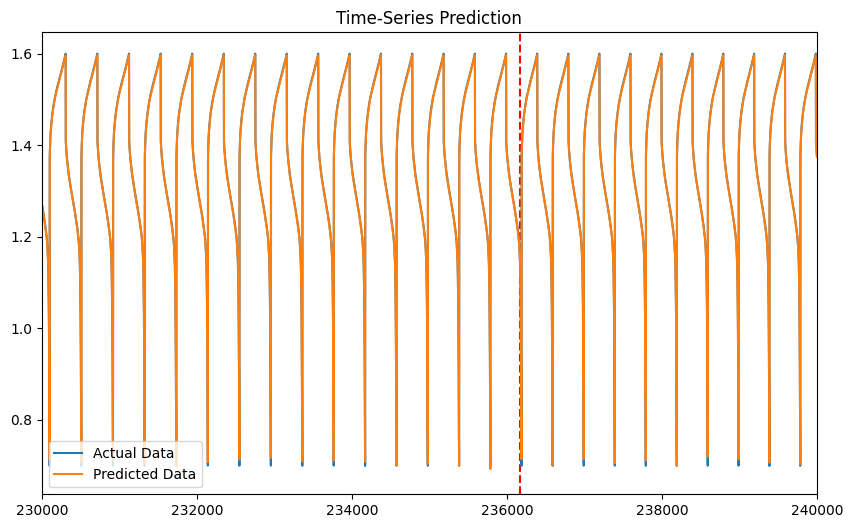

In [12]:
df_x_ss = dataset.x
df_y_ms = dataset.y

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

train_predict = model(df_x_ss)
predicted = train_predict.data.numpy() 
label_y = df_y_ms.data.numpy()


plt.figure(figsize=(10,6)) 
plt.axvline(x=dataset_size-test_size, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.xlim([230000, 240000])
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

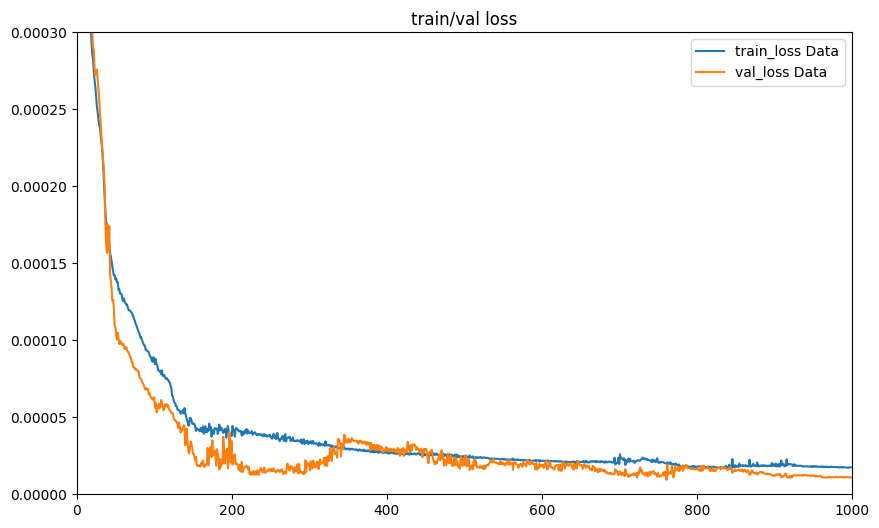

In [13]:
plt.figure(figsize=(10,6))

plt.plot(train_loss, label='train_loss Data')
plt.plot(val_loss, label='val_loss Data')
plt.title('train/val loss')
plt.xlim([0, 1000])
plt.ylim([0, 0.0003])
plt.legend()
plt.show()

In [14]:
print("train_loss(990~1000) : ",np.mean(train_loss[990:1000]))
#print(np.mean(val_loss[990:1000]))

train_loss(990~1000) :  1.7414444426602063e-05
